# Scraping monsters and anticipating ACs to estimate critical threat probabilities

In d&d 3.5e, rolling a "critical" is an exciting event. You get to do extra damage to the monsters you are fighting and everyone always is rather excited to roll high when it happens. While the traditional critical happens when you roll 20 on the 20 sided die, some weapons have a larger range. Calculating the probability of rolling a number in this range is fairly straightforward:

| critical threat range | probability |
|-----------------------|-------------|
| 20                    | 0.05        |
| 19-20                 | 0.10        |
| 18-20                 | 0.15        |

Basically, the more sides of a die, the more increments of 0.05 you get in probability. While this step is straightforward, actually succeeding and thus causing critical damage is more complex.

After your first successful critical roll you must again roll against the [Armor Class (AC)](http://www.d20srd.org/srd/combat/combatStatistics.htm) of the creature you are attacking. This produces an unknown since we typically do not know the AC of the creature we are attacking (the information is hidden by the dungeon master). Thus it becomes difficult to antipate the probability of successfully checking your critical. This notebook stands to provide some insight into these probabilities.

The goal of this notebook is to do the following:

1. scrape all the stats of monsters on the [d&d 3.5e SRD](https://d20srd.org)
2. Calculate the average/distribution of ACs of monsters that sum to appropriate [encounter levels](http://www.d20srd.org/srd/monsters/intro.htm#challengeRating) for parties level 1-20
3. Calculate the probabilities of critical threats based on different critical threat ranges for each party level based on the established distribution of ACs

## What are Encounter Levels?

Encounter levels are an inaccurate measurement of how difficult a battle will be for a party of level X. A 4th level party (i.e., all the party members are level 4 characters) fighting a battle of Encounter level 4 should have a reasonable amount of difficulty in the encounter. Greater than 4 its more difficult, less than 4 it is more easy. I say this is "inaccurate" because ultimately there are many things that go into whether an encounter is difficult or easy (feats and abilities, magic items the party possesses, etc.). But basically, it's all we got to generate a list of monsters suitable to fight a specific party. To generate an encounter level we sum the challenge ratings of the monsters the party is fighting. So if a zombie has a Challenge rating  of 1/2 and we have a level 4 party, they should fight 8 zombies to provide an adequate challenge.

## Caveats

1. Currently, if there is more than one table describing a monster in the monster description, only the first table is included, this will probably bias the monster statistics negatively since it typically shows the least powerful monster first

In [1]:
%matplotlib inline

import bs4 as bs
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

This pulls the list of links from the srd website for all the monsters. They are formatted in 'columns' right now the code beneath only looks at the first column (`monster_cols[0]`) but this can be changed with a simple for loop

In [2]:
source = urllib.request.urlopen('http://www.d20srd.org/indexes/monsters.htm').read()
soup = bs.BeautifulSoup(source,'lxml')
monster_cols = soup.findAll('ul', {'class':'column'})

Some of the links here have sub links, thus we split on the '#' and then remove the duplicates with the list/set combo. We are probably losing some of the creatures since there is sometimes creatures that are coming in different strengths and weaknesses but thats fine for now.

In [3]:
parsed_links = []

for col in monster_cols:
    links = col.findAll('a', href=True)
    for link in links:
        beginning = 'http://www.d20srd.org'
        link = beginning + link['href'].split('#')[0]
        parsed_links.append(link)

parsed_links = list(set(parsed_links))
print('number of monsters:', len(parsed_links))

number of monsters: 248


Here we take out all of the data in the statBlocks and turn it into data that will fit into a pandas dataframe. Note the comment in the try/except block. There will need to be more parsing of data done before its in a format that lends itself to statistics, but getting all the data into a tabulated format is important first, then we can tease apart the rest.

In [4]:
from IPython.display import clear_output

errors = []
data_length = []
for i, link in enumerate(parsed_links):
    if i % 3:
        clear_output()
    source = urllib.request.urlopen(link).read()
    soup = bs.BeautifulSoup(source, 'lxml')
    table = soup.findAll('table', {'class': 'statBlock'})
    try:
        table_rows = table[0].findAll('tr')
        rows = []
        for tr in table_rows:
            rows.append(tr.text)

        data = []
        data.append(['Link', link])
        for row in rows:
            data.append(row.split('\n')[1:3])


        if 'df' not in locals():
            print('df created . . .')
            df = pd.DataFrame()
            df = pd.concat([df, pd.DataFrame(dict(data), index=(i,))])
        else:
            df = pd.concat([df, pd.DataFrame(dict(data), index=(i,))], sort=False)
            print('df row {n} appended . . .'.format(n=i))
        errors.append(0)
        data_length.append(len(data))

    except IndexError:
        """
        The exceptions here are okay because they are excepting out data
        that isn't appearing in the format. That is there is no statBlock
        data in the links being searched so they are excepted out.
        """
        errors.append(1)
        data_length.append(len(data))

        
error_analysis = pd.DataFrame({'errors':errors, 'data_length':data_length, 'links':parsed_links})

df row 247 appended . . .


In [5]:
"""
all of these are monster pages that do not have any monster statistics blocks
in them
"""

error_analysis[error_analysis.errors > 0]

,errors,data_length,links
4,1,23,http://www.d20srd.org/srd/monsters/direAnimal.htm
72,1,23,http://www.d20srd.org/srd/monsters/lich.htm
75,1,24,http://www.d20srd.org/srd/monsters/halfDragon.htm
82,1,21,http://www.d20srd.org/srd/monsters/halfCelesti...
133,1,23,http://www.d20srd.org/srd/monsters/fiendishCre...
152,1,23,http://www.d20srd.org/srd/monsters/halfFiend.htm
195,1,21,http://www.d20srd.org/srd/monsters/celestialCr...
207,1,23,http://www.d20srd.org/srd/monsters/ghost.htm


In [6]:
"""
There may be some duplicates here, lets get rid of them

Also, since we care so much about AC, rows with NaN ACs are 
useless. drop them too.

TODO: inspect the input data so there is no duplicates anymore
"""

df.drop_duplicates(inplace=True)
df = df[~df['Armor Class:'].isnull()].copy()

In [7]:
df['Title'] = df.Link.apply(lambda row: row.split('/')[-1].split('.')[0])

In [8]:
df.shape

(239, 26)

Thus the raw data is parsed and we now have stats for 240 monsters 


In [9]:
df.columns

Index(['Link', 'Size/Type:', 'Hit Dice:', 'Initiative:', 'Speed:',
       'Armor Class:', 'Base Attack/Grapple:', 'Attack:', 'Full Attack:',
       'Space/Reach:', 'Special Attacks:', 'Special Qualities:', 'Saves:',
       'Abilities:', 'Skills:', 'Feats:', 'Environment:', 'Organization:',
       'Challenge Rating:', 'Advancement:', 'Level Adjustment:', 'Treasure:',
       'Alignment:', '', 'Type:', 'Title'],
      dtype='object')

In [10]:
"""
Converting AC into integers helps with statistics

This ignores touch AC or flat footed AC
"""

df['AC(int)'] = df['Armor Class:'].apply(lambda row: row.split(' ')[0]).astype(int)

In [11]:
"""
Challenge ratings can be fractional (e.g., goblins are weak but often
there are a lot of them). Thus we need a function that will convert the
fractional strings into floats so we can do statistics.

Additionally, there is some string handling that is done because sometimes
there are 
"""

def get_float_from_fraction_str(fraction):
    fraction = fraction.split('/')
    numerator = float(fraction[0])
    denominator = float(fraction[1])
    return numerator/denominator

def convert_challenge_rating(CR):
    CR_len = len(CR.split('/'))
    if '/' in CR:
        return get_float_from_fraction_str(CR)
    elif ' ' in CR:
        return CR.split(' ')[0]
    else:
        try:
            return float(CR)
        except ValueError:
            import unicodedata
            return unicodedata.numeric(CR)

In [12]:
df['CR(float)'] = df['Challenge Rating:'].apply(convert_challenge_rating).astype(float)

In [13]:
df[['AC(int)', 'CR(float)']].describe()

,AC(int),CR(float)
count,239.000000,239.000000
mean,17.062762,4.217015
std,4.100655,3.642407
min,3.000000,0.100000
25%,15.000000,1.000000
50%,16.000000,3.000000
75%,18.000000,6.000000
max,38.000000,21.000000


''

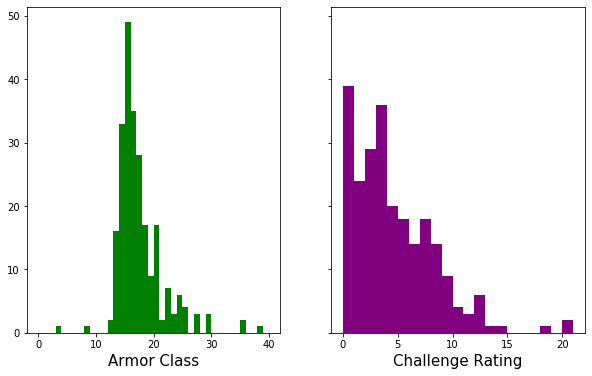

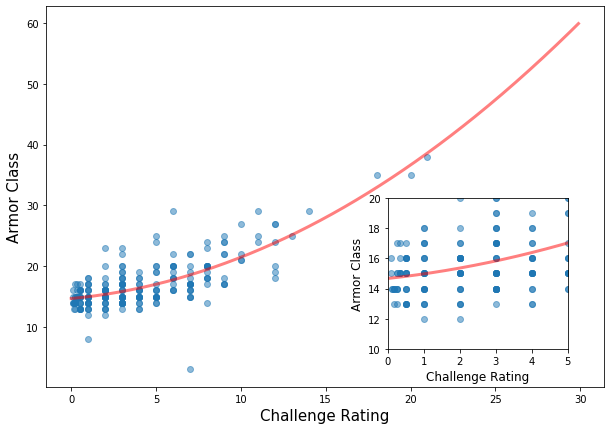

In [14]:
fig, (ax, ax2)= plt.subplots(1, 2, figsize=(10, 6), sharey=True)

df['AC(int)'].hist(bins=np.arange(0, 41, 1), grid=False, ax=ax, color='green')
df['CR(float)'].hist(bins=np.arange(0, 22, 1), grid=False, ax=ax2, color='Purple')

ax.set_xlabel('Armor Class', fontsize=15)
ax2.set_xlabel('Challenge Rating', fontsize=15)

fig, ax3 = plt.subplots(figsize=(10, 7))

ax3.scatter(x=df['CR(float)'].values, y=df['AC(int)'].values, alpha=0.5)
ax3.set_xlabel('Challenge Rating', fontsize=15)
ax3.set_ylabel('Armor Class', fontsize=15)

ax4 = fig.add_axes([0.6, 0.2, 0.25, 0.3])
ax4.scatter(x=df['CR(float)'].values, y=df['AC(int)'].values, alpha=0.5)
ax4.set_xlim(0, 5)
ax4.set_ylim(10, 20)
ax4.set_ylabel('Armor Class', fontsize=12)
ax4.set_xlabel('Challenge Rating', fontsize=12)

p = np.poly1d(np.polyfit(x=df['CR(float)'].values, y=df['AC(int)'].values, deg=2))
x = np.arange(0, 30, 0.1)
y = p(x)
ax3.plot(x, y, color='red', linewidth=3, alpha=0.5)
ax4.plot(x, y, color='red', linewidth=3, alpha=0.5)

"""
As I expected, there is a somewhat linear relation between challenge rating
and armor class, that is, as challenge rating goes up, so does armor class.

Armor class seems to be roughly normally distributed, whereas challenge rating
seems to be rougly poisson distributed.
"""
''

Calculating the average AC for encounters that the party will encounter

1. for each level party, assume that there are 4 players built exclusively
from the SRD.

2. build a sub database of monsters of the CR equal to the party and lower

3. Bootstrap encounters from the sub database for the appropriate ECL

4. Calculate average AC

5. Calculate probability to crit successfully for attack modifiers +1 to +10


In [15]:
AC_df = df[['Link', 'Title', 'AC(int)', 'CR(float)']].copy()

In [16]:
# AC_df[AC_df['CR(float)'] <= 4].sample(n=1)['Title'].values[0]

In [17]:
def get_monster(monster_db):
    monster = monster_db.sample(n=1)
    monster_ac = monster['AC(int)'].values[0]
    monster_cr = monster['CR(float)'].values[0]
    monster_name = monster['Title'].values[0]
    return {'name':monster_name, 'cr':monster_cr, 'ac':monster_ac}


def get_party_at_ECL(ECL, monster_db):
    monster_db = monster_db[monster_db['CR(float)'] < ECL].copy()
    
    cr = 0
    monsters = []

    while cr < ECL:
        monster = get_monster(monster_db)
#         print(monster)
        cr += monster['cr']
        monsters.append(monster)
#         print('cr:', cr)
        
    return monsters
    
get_party_at_ECL(ECL=9, monster_db=df)

[{'name': 'ooze', 'cr': 7.0, 'ac': 3},
 {'name': 'direBadger', 'cr': 2.0, 'ac': 16}]

In [18]:
"""
Here we create the randomly sampled database of encounters per level 

"""

party_levels = np.arange(1, 21, 1)

level_dfs = []

for level in party_levels:
    
    level_df = pd.DataFrame()
    
    for i in np.arange(1000):
        level_df = pd.concat([level_df, pd.DataFrame(get_party_at_ECL(ECL=level, monster_db=df))])
        
    level_dfs.append(level_df)
    

''

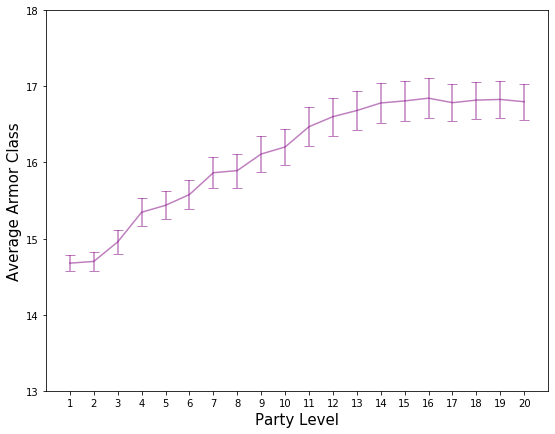

In [19]:
avg_ac = np.array([level['ac'].mean() for level in level_dfs])
sem_ac = np.array([level['ac'].sem() for level in level_dfs])

fig, ax = plt.subplots(figsize=(9, 7))

ax.errorbar(x=party_levels, y=avg_ac, yerr=sem_ac*5, alpha=0.5, color='Purple', capsize=5)

ax.set_xlim(0, 21)
ax.set_xticks(party_levels)

ax.set_ylim(13, 18)

ax.set_ylabel('Average Armor Class', fontsize=15)
ax.set_xlabel('Party Level', fontsize=15)

"""
This plot was created by randomly sampling 1000 encounters per party level to produce
a sub-database of Armor Classes. These ACs are then average and the 5 sigma SEM is
calculated (thus producing the error bars).
"""
''

# Probability to beat the AC

To calculate the probability to beat an AC we need the following information:

1. The [attack modifier the player will use](http://www.d20srd.org/srd/combat/combatStatistics.htm#attackBonus)
2. The average AC that the player will encounter

For a single attack a player rolls a 20-sided die and adds the attack modifier, if its equal or higher to the AC, you hit. If the number on the die is equal to or higher than the minimum threat range, you have have threatened a critical. A subsequent role will determine if the critical threat succeeds. For a 20 sided die, to roll any one side the probability is 1/20. Thus for a longsword whose critical threat range is 19-20 then the probability to threaten is 1/10. If the player has an attack modifier of +6 and the monster they attack has an AC of 12 than the probability of successfully critically damaging is:

$$P(crit success) = P(roll 19 or 20) * P(roll >= AC)$$

Where

$$P(roll >= AC) = 1 - (AC - modifier)/20$$

Thus

$$P(crit success) = 2/20 * [1 - (12 - 6)/20] = 2/20 * (1 - 6/20) = 0.07$$

Doing this for the range of attack modifiers between +1 and +20 produces the below plot for a single attack.

Assuming your base attack bonus is at least +6, you get an extra attacks for full round attacks. Thus the probability for these full round actions of a single successsful critical occurs changes. Because each attack is independent from each other attack we will combine the probabilities. This will produce the probability per round (or density) of a successful critical occurring.

$$P(crit success) = P(roll_1 19 or 20) * P(roll_1 >= AC) * P(roll_2 19 or 20) * P(roll_2 >= AC)$$

Where

$$P(roll_1 >= AC) = 1 -(AC - modifier_1)/20 = 1 - (12 - 6)/20 = 0.7$$

and

$$P(roll_2 >= AC) = 1 - (AC - modifier_2)/20 = 1 - (12 - 1)/20 = 0.45$$

Thus

$$P(crit success) = 2/20 * 0.7 + 2/20 * 0.45 = 0.1145$$

As we can see, the more you attack the more liekly you are to have a critical success.

In [20]:
probability_of_threats = (np.abs(np.arange(15, 21, 1)-20)+1)/20 # for threat ranges of 15-20 to 20

average_modifier = np.arange(0, 20, 1) # assuming a stat of 10 or 11 for STR or DEX

probability_to_beat_ac = 1 - (avg_ac - average_modifier)/20

Text(0.5, 1.0, 'A single attack at full attack')

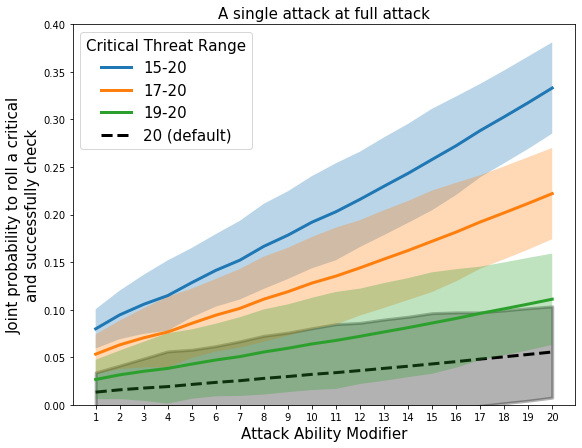

In [21]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(party_levels, probability_to_beat_ac*0.3, label='15-20', linewidth=3)
ax.fill_between(x=party_levels, y1=probability_to_beat_ac*0.3-sem_ac, y2=probability_to_beat_ac*0.3+sem_ac, label=None, linewidth=3, alpha=0.3)

# ax.plot(party_levels, probability_to_beat_ac*0.25, label='16-20', linewidth=3, linestyle='--')

ax.plot(party_levels, probability_to_beat_ac*0.2, label='17-20', linewidth=3)
ax.fill_between(x=party_levels, y1=probability_to_beat_ac*0.2-sem_ac, y2=probability_to_beat_ac*0.2+sem_ac, label=None, linewidth=3, alpha=0.3)

# ax.plot(party_levels, probability_to_beat_ac*0.15, label='18-20', linewidth=3, linestyle='--')

ax.plot(party_levels, probability_to_beat_ac*0.1, label='19-20', linewidth=3)
ax.fill_between(x=party_levels, y1=probability_to_beat_ac*0.1-sem_ac, y2=probability_to_beat_ac*0.1+sem_ac, label=None, linewidth=3, alpha=0.3)

ax.plot(party_levels, probability_to_beat_ac*0.05, label='20 (default)', linewidth=3, linestyle='--', color='black', zorder=0)
ax.fill_between(x=party_levels, y1=probability_to_beat_ac*0.05-sem_ac, y2=probability_to_beat_ac*0.05+sem_ac, label=None, linewidth=3, alpha=0.3, color='black', zorder=0)

leg = ax.legend(fontsize=15)
leg.set_title('Critical Threat Range',prop={'size':15})
ax.set_ylabel('Joint probability to roll a critical\nand successfully check', fontsize=15)
ax.set_xlabel('Attack Ability Modifier', fontsize=15)

ax.set_xticks(party_levels)
ax.set_ylim(0, 0.4)
ax.set_title('A single attack at full attack', fontsize=15)

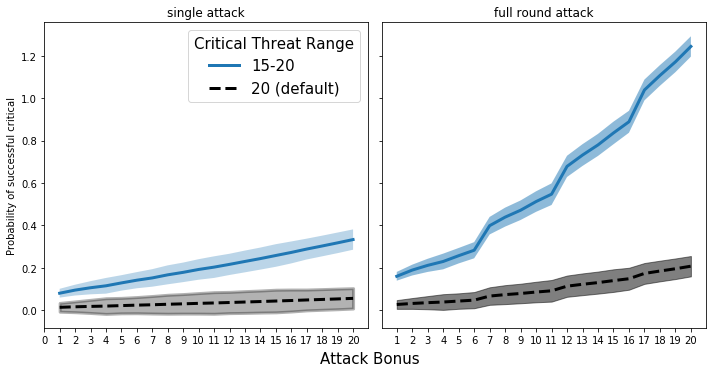

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)

ax[0].set_title('single attack')
ax[1].set_title('full round attack')

ax[0].plot(party_levels, probability_to_beat_ac*0.3, label='15-20', linewidth=3)
ax[0].fill_between(x=party_levels, y1=probability_to_beat_ac*0.3-sem_ac, y2=probability_to_beat_ac*0.3+sem_ac, label=None, linewidth=3, alpha=0.3)

ax[0].plot(party_levels, probability_to_beat_ac*0.05, label='20 (default)', linewidth=3, linestyle='--', color='black', zorder=0)
ax[0].fill_between(x=party_levels, y1=probability_to_beat_ac*0.05-sem_ac, y2=probability_to_beat_ac*0.05+sem_ac, label=None, linewidth=3, alpha=0.3, color='black', zorder=0)

def full_round_attack(attack_modifier, threat_range):
    if attack_modifier < 6:
        return probability_to_beat_ac[attack_modifier]*threat_range + probability_to_beat_ac[attack_modifier]*threat_range
    elif attack_modifier >= 6 and attack_modifier < 11:
        return probability_to_beat_ac[attack_modifier]*threat_range + probability_to_beat_ac[attack_modifier]*threat_range + probability_to_beat_ac[attack_modifier-5]*threat_range
    elif attack_modifier >= 11 and attack_modifier < 16:
        return probability_to_beat_ac[attack_modifier]*threat_range + probability_to_beat_ac[attack_modifier]*threat_range  + probability_to_beat_ac[attack_modifier-5]*threat_range + probability_to_beat_ac[attack_modifier-10]*threat_range
    else:
        return probability_to_beat_ac[attack_modifier]*threat_range + probability_to_beat_ac[attack_modifier]*threat_range + probability_to_beat_ac[attack_modifier-5]*threat_range+ probability_to_beat_ac[attack_modifier-10]*threat_range+ probability_to_beat_ac[attack_modifier-15]*threat_range

full_round_1520 = [full_round_attack(a, 0.3) for a in np.arange(0, 20, 1)]       
full_round_20 = [full_round_attack(a, 0.05) for a in np.arange(0, 20, 1)]       
  
ax[1].plot(party_levels, full_round_1520, label='15-20', linewidth=3)
ax[1].fill_between(party_levels, full_round_1520-sem_ac, full_round_1520+sem_ac, alpha=0.5)

ax[1].plot(party_levels, full_round_20, label='20', linewidth=3, color='black', linestyle='--')
ax[1].fill_between(party_levels, full_round_20-sem_ac, full_round_20+sem_ac, alpha=0.5, color='black')

leg = ax[0].legend(fontsize=15)
leg.set_title('Critical Threat Range',prop={'size':15})

ax[0].set_ylabel('Probability of successful critical')
fig.text(s='Attack Bonus', x=0.45, y=-0.02, fontsize=15)

ax[0].set_xticks(np.arange(0, 21, 1))
fig.tight_layout()

In [23]:

p = probability_to_beat_ac[13-2]*0.1 + probability_to_beat_ac[13-2]*0.1 + probability_to_beat_ac[7-2]*0.1 + probability_to_beat_ac[7-5]*0.1 

print('probability for ulrik von bek to have one successful critical strike in one round:', p)

probability for ulrik von bek to have one successful critical strike in one round: 0.2263023361793089


In [24]:

p = probability_to_beat_ac[13-2]*0.15 + probability_to_beat_ac[13-2]*0.15 + probability_to_beat_ac[7-2]*0.15 + probability_to_beat_ac[7-5]*0.15 

print('probability for ulrik von bek to have one successful critical strike in one round:', p)

probability for ulrik von bek to have one successful critical strike in one round: 0.3394535042689633


# How was this final plot created from start to finish?

The process to create this plot is hopefully evident from the code itself, however, I will break it down here.

1. Data from [d20SRD monster database](http://www.d20srd.org/indexes/monsters.htm) was scraped and processed to produce a collection of armor classes
2. Using the challenge ratings of the creatures, we calculuate encounter levels of 1000 separate encounters and put them into a dataframe for encounter levels 1 through 20
3. This allows us to produce average ACs to calculate the second probability of success
4. Calculating the joint probability of successfully rolling a critical ( P(roll within critical threat range) * P(succeeding against average AC) )
5. Plot is produced

# What results can we derive from this analysis?

Obviously, the best way to increase your chances of rolling a successful critical is by increasing the critical threat range of your weapon. It's also apparent that successfully rolling a critical strike is much smaller than the probability of simply rolling in the critical threat range and the only way to increase this is to increase the attack ability modifier. To increase the critical threat range you have several options.

You can do this by using the [keen spell](http://www.d20srd.org/srd/spells/keenEdge.htm), by taking the feat [Improved Critical](http://www.d20srd.org/srd/feats.htm#improvedCritical), or by using a magical weapon with the [keen ability](http://www.d20srd.org/srd/magicItems/magicWeapons.htm#keen). Unfortunately none of these stack so all things being equal, the best choice is to take Improved Critical (which requires a base attack bonus of +8).

Beyond using weapons with magical damage, increasing your ability to successfully roll critical threats is good way to deal more damage. Additionally, the more times you get to roll, the higher the likelihood that you will successfully roll a critical threat.

Additionally, this shows that [vorpal weapons](http://www.d20srd.org/srd/magicItems/magicWeapons.htm#vorpal) are basically useless because they require a natural 20 thus the maximum joint probability can never be much more than 5% (see the black line in the plot above). Thus the likelihood of a vorpal weapon striking true (and thus instantly killing an enemy by severing their head) is less than 1 in 20 attacks. This makes increasing your critical threat range even more enticing (compared to a vorpal sword) because of the [massive damage rules](http://www.d20srd.org/srd/combat/injuryandDeath.htm#massiveDamage). By maximizing critical damage you make it more likely to deal at least 50 points of damage in a single hit. I will add later the probability of doing 50 points of damage or more later.

